In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

from sklearn.linear_model import RidgeCV, LassoCV, LassoLarsCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score, KFold, learning_curve, GridSearchCV
from scipy.stats.stats import pearsonr

warnings.filterwarnings("ignore")

## Loading data and checking the distribution of 'SalePrice'

In [2]:
# Loading CSV files

df_houses_train = pd.read_csv('train.csv')
df_houses_test = pd.read_csv('test.csv')

# Keeping the Id's

id_train = df_houses_train['Id']
id_test = df_houses_test['Id']

# Dropping the Id column because is not useful to make predictions

df_houses_train.drop(['Id'], axis=1, inplace=True)
df_houses_test.drop(['Id'], axis=1, inplace=True)

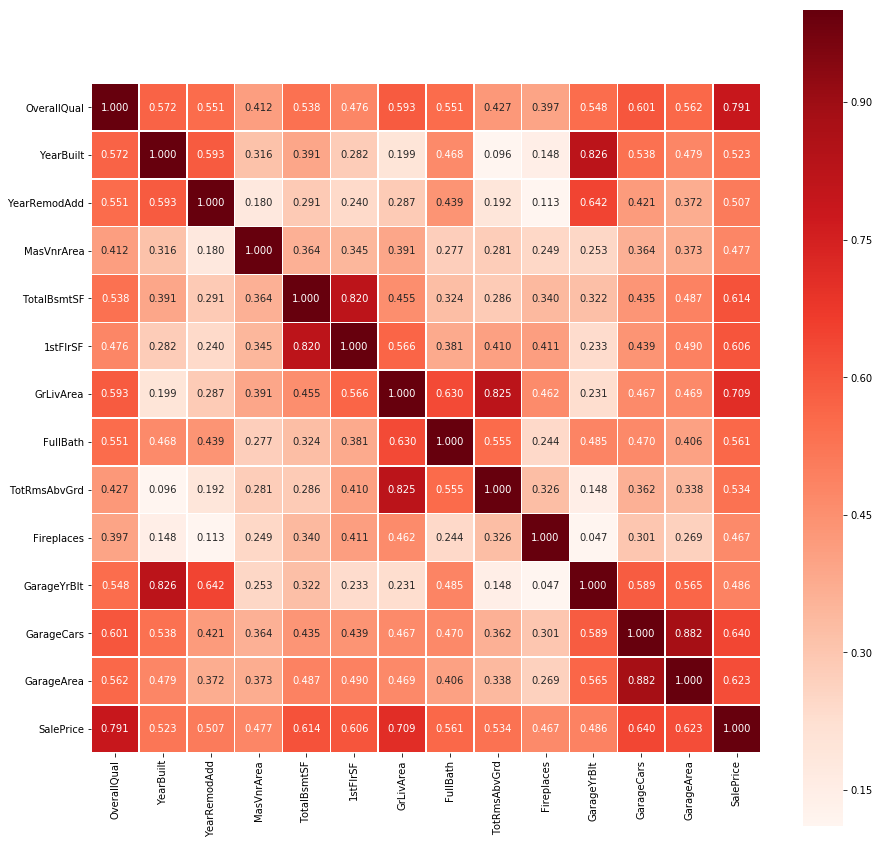

In [3]:
# See the correlation among the features

corr = df_houses_train.corr()
top_corr = corr.index[abs(corr["SalePrice"]) > 0.45]

f,ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_houses_train[top_corr].corr(), 
            annot=True, 
            linewidths=.4, 
            fmt='.3f', 
            robust=True,
            ax=ax, 
            cmap='Reds',
            square=True);

<font color="blue" size=3><b>OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, FullBath, YearBuilt and TotRmsAbvGrd are more correlated to SalePrice.<br>
TotalBsmtSF and 1stFlrSF have a string correlation.<br>
GrLivArea and TotRmsAbvGrd have a strong correlation.<br>
GarageCars and GarageArea have a strong correlation.<br>
GarageYrBlt and YearBuilt have a strong correlation.
</b></font>

In [4]:
# Removing some columns

del df_houses_train['1stFlrSF']
del df_houses_train['TotRmsAbvGrd']
del df_houses_train['GarageArea']
del df_houses_train['GarageYrBlt']

del df_houses_test['1stFlrSF']
del df_houses_test['TotRmsAbvGrd']
del df_houses_test['GarageArea']
del df_houses_test['GarageYrBlt']

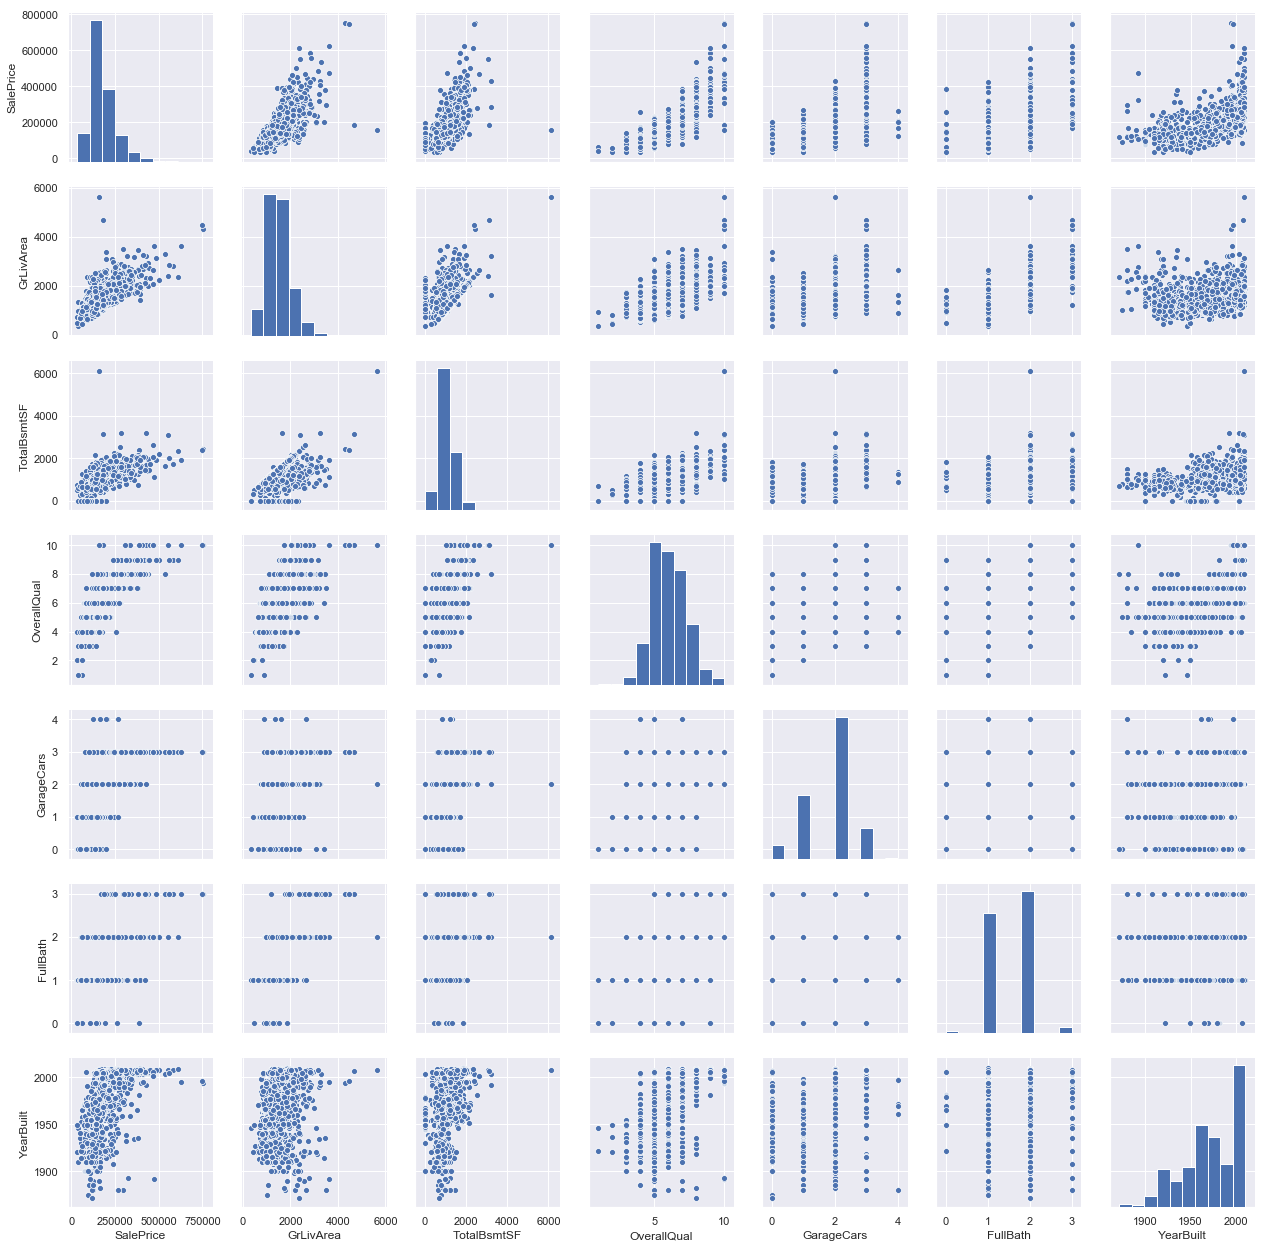

In [5]:
sns.set()
columns = ['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'OverallQual', 'GarageCars', 'FullBath', 'YearBuilt']
sns.pairplot(df_houses_train[columns]);

Correlation (with outliers)   : 0.708624477612652
Correlation (with no outliers): 0.7349681645359327


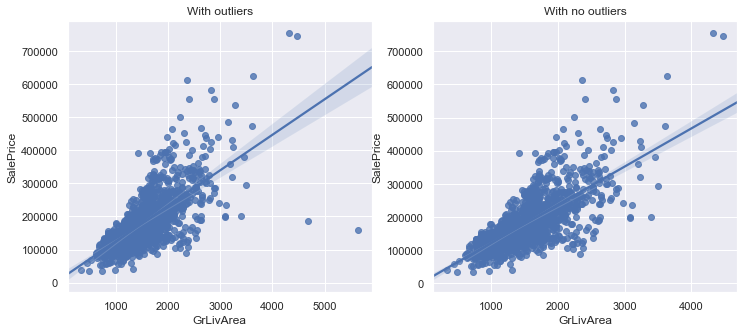

In [6]:
# GrLivArea

plt.subplots(figsize=(12, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x = df_houses_train['GrLivArea'], 
                y = df_houses_train['SalePrice'], 
                fit_reg=True).set_title("With outliers")

print('Correlation (with outliers)   :', 
      pearsonr(df_houses_train['SalePrice'], df_houses_train['GrLivArea'])[0])

# Deleting outliers

condition = ((df_houses_train['GrLivArea']>4000) & (df_houses_train['SalePrice']<300000))
df_houses_train = df_houses_train.drop(df_houses_train[condition].index).reset_index(drop=True)

plt.subplot(1, 2, 2)
g = sns.regplot(x = df_houses_train['GrLivArea'], 
                y = df_houses_train['SalePrice'], 
                fit_reg=True).set_title("With no outliers")

print('Correlation (with no outliers):', 
      pearsonr(df_houses_train['SalePrice'], df_houses_train['GrLivArea'])[0])

Correlation (with outliers)   : 0.6511529110475418
Correlation (with no outliers): 0.6529720902241524


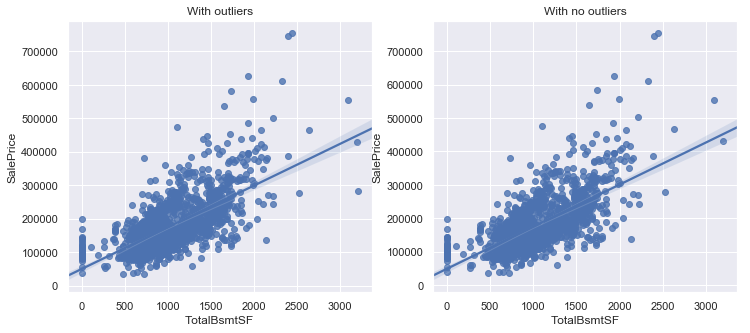

In [7]:
# TotalBsmtSF

plt.subplots(figsize=(12, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x = df_houses_train['TotalBsmtSF'], 
                y = df_houses_train['SalePrice'], 
                fit_reg=True).set_title("With outliers")

print('Correlation (with outliers)   :', 
      pearsonr(df_houses_train['SalePrice'], df_houses_train['TotalBsmtSF'])[0])

# Deleting outliers

#condition = df_houses_train['TotalBsmtSF']>3000
condition = ((df_houses_train['TotalBsmtSF'] > 3000) & (df_houses_train['SalePrice'] < 300000))
df_houses_train = df_houses_train.drop(df_houses_train[condition].index).reset_index(drop=True)

plt.subplot(1, 2, 2)
g = sns.regplot(x = df_houses_train['TotalBsmtSF'], 
                y = df_houses_train['SalePrice'], 
                fit_reg=True).set_title("With no outliers")

print('Correlation (with no outliers):', 
      pearsonr(df_houses_train['SalePrice'], df_houses_train['TotalBsmtSF'])[0])

In [8]:
def get_avg_totalbsmt(col):
        mean = df_houses_train['TotalBsmtSF'].mean()
        return col if col != 0 else mean

Correlation (with outliers)   : 0.7955242519533297
Correlation (with no outliers): 0.8005996975326845


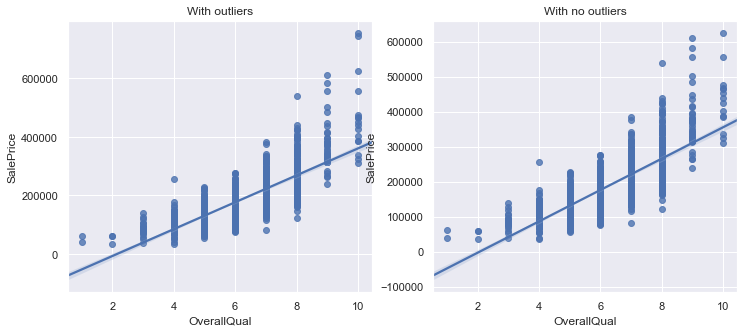

In [9]:
# OverallQual

plt.subplots(figsize=(12, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x = df_houses_train['OverallQual'], 
                y = df_houses_train['SalePrice'], 
                fit_reg=True).set_title("With outliers")

print('Correlation (with outliers)   :', 
      pearsonr(df_houses_train['SalePrice'], df_houses_train['OverallQual'])[0])

# Deleting outliers

condition = ((df_houses_train['OverallQual']==10) & (df_houses_train['SalePrice']>650000))
df_houses_train = df_houses_train.drop(df_houses_train[condition].index).reset_index(drop=True)

plt.subplot(1, 2, 2)
g = sns.regplot(x = df_houses_train['OverallQual'], 
                y = df_houses_train['SalePrice'], 
                fit_reg=True).set_title("With no outliers")

print('Correlation (with no outliers):', 
      pearsonr(df_houses_train['SalePrice'], df_houses_train['OverallQual'])[0])

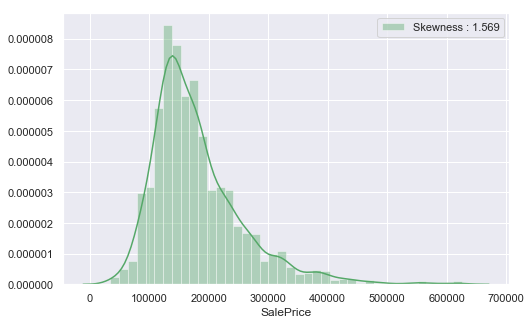

In [10]:
# View the distribution of SalePrice

fig, ax = plt.subplots(figsize=(8,5))
g = sns.distplot(df_houses_train["SalePrice"], 
                 color="g", 
                 label="Skewness : %.3f"%(df_houses_train["SalePrice"].skew()), 
                 hist_kws=dict(edgecolor="w", linewidth=1), ax=ax)
                 
g = g.legend(loc="best")

In [11]:
# Using log1p to get a better distribution

df_houses_train["SalePrice"] = np.log1p(df_houses_train["SalePrice"])

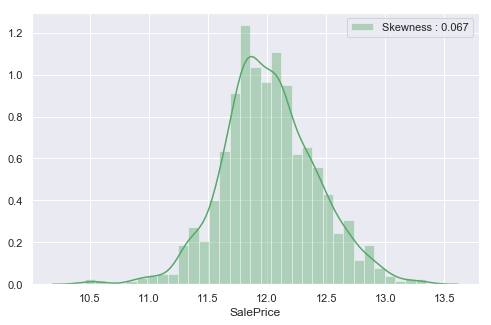

In [12]:
# View the distribution of SalePrice after applying Log

fig, ax = plt.subplots(figsize=(8,5))
g = sns.distplot(df_houses_train["SalePrice"], 
                 color="g", 
                 label="Skewness : %.3f"%(df_houses_train["SalePrice"].skew()), 
                 hist_kws=dict(edgecolor="w", linewidth=1),
                 ax=ax)
                 
g = g.legend(loc="best")

In [13]:
# Joining both datasets

train_size = len(df_houses_train)
y_train = df_houses_train['SalePrice']

all_houses =  pd.concat((df_houses_train, df_houses_test)).reset_index(drop=True)
all_houses.drop(['SalePrice'], axis=1, inplace=True)

# Filling empty values with NaN and checking the null values

all_houses.fillna(np.nan, inplace=True)
all_houses.head()

,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition,SaleType,ScreenPorch,Street,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,854,0,NaN,3,1Fam,TA,No,706.0,0.0,GLQ,...,Normal,WD,0,Pave,856.0,AllPub,0,2003,2003,2008
1,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,ALQ,...,Normal,WD,0,Pave,1262.0,AllPub,298,1976,1976,2007
2,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,GLQ,...,Normal,WD,0,Pave,920.0,AllPub,0,2001,2002,2008
3,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,ALQ,...,Abnorml,WD,0,Pave,756.0,AllPub,0,1915,1970,2006
4,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,GLQ,...,Normal,WD,0,Pave,1145.0,AllPub,192,2000,2000,2008


In [14]:
# Normalising a column of values between 0 and 1

def normal_minmax(col):
    return (col - col.min())/(col.max() - col.min())

## Filling missing values

In [15]:
# Amount of null values

all_houses.isnull().sum().sort_values(ascending=False).head(35)

PoolQC          2906
MiscFeature     2809
Alley           2716
Fence           2344
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      79
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
KitchenQual        1
Exterior1st        1
Exterior2nd        1
GarageCars         1
SaleType           1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Foundation         0
3SsnPorch          0
BedroomAbvGr       0
dtype: int64

#### Filling with NA

In [16]:
columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
           'MasVnrType',
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for col in columns:
    all_houses[col] = all_houses[col].fillna('None')

#### Filling with 0 (zero) - No garage, no basement, no masonry veneer

In [17]:
columns = ['GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
           'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

for col in columns:
    all_houses[col] = all_houses[col].fillna(0)

In [18]:
df_houses_train['TotalBsmtSF_AVG'] = df_houses_train['TotalBsmtSF'].apply(get_avg_totalbsmt)

#### Filling with other values - MSZoning, LotFrontage, Functional, Utilities, Exterior1st, Exterior2nd, KitchenQual, SaleType and Electrical

In [19]:
columns = ['MSZoning', 'Functional', 'Utilities', 'Exterior1st', 'Exterior2nd',
           'KitchenQual', 'SaleType', 'Electrical']

for col in columns:
    print('Column [ {0} ] - Mode: {1}'.format(col, all_houses[col].mode()[0])) # Mode of the column
    all_houses[col] = all_houses[col].fillna(all_houses[col].mode()[0])

Column [ MSZoning ] - Mode: RL
Column [ Functional ] - Mode: Typ
Column [ Utilities ] - Mode: AllPub
Column [ Exterior1st ] - Mode: VinylSd
Column [ Exterior2nd ] - Mode: VinylSd
Column [ KitchenQual ] - Mode: TA
Column [ SaleType ] - Mode: WD
Column [ Electrical ] - Mode: SBrkr


In [20]:
# LotFrontage: Linear feet of street connected to property

all_houses['LotFrontage'] = all_houses.groupby('Neighborhood')['LotFrontage'].transform(
    lambda lotFrontage: lotFrontage.fillna(lotFrontage.median())) # Median of the neighborhood

#### Changing some features

In [21]:
# Replacing name of the month by corresponding number

all_houses = all_houses.replace({'MoSold': {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                                            7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov',12: 'Dec'}})

In [22]:
# Converting YrSold to string

all_houses['YrSold'] = all_houses['YrSold'].astype(str)

In [23]:
# Replacing MSSubClass by a combinated name

for subclass in all_houses['MSSubClass'].unique():
    all_houses = all_houses.replace({'MSSubClass': {subclass : 'SubClass_' + str(subclass)}})

In [24]:
# Creating categories using ordered features

cat_features = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
                'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional', 'GarageCond', 
                'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual', 'PavedDrive', 'PoolQC', 'Utilities']

for feature in cat_features:
    all_houses[feature] = all_houses[feature].astype("category")
    
all_houses = all_houses.replace({
"BsmtExposure" : {"None" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
"BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
"BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
"Fence" : {"None" : 0, "MnWw" : 1, "GdWo": 2, "MnPrv" : 3, "GdPrv" : 4},
"Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
"GarageFinish" : {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
"PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
"Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}})

all_houses['CentralAir'].replace({'Y':1,'N':0}, inplace=True)

In [25]:
columns = ['ExterQual','ExterCond','BsmtQual','BsmtCond', 'HeatingQC','KitchenQual',
           'FireplaceQu','GarageQual', 'GarageCond','PoolQC']
values = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}

for col in columns:
    all_houses[col].replace(values, inplace=True)  

In [26]:
# Amount of numeric and string features

string_features = all_houses.select_dtypes(include=['object']).columns
numeric_features = all_houses.select_dtypes(include=['int64', 'float64']).columns

In [27]:
# Normalizing the numeric data

all_houses[numeric_features] = all_houses[numeric_features].apply(normal_minmax)

#### Checking the skewness of all numeric features

In [28]:
skewed_features = all_houses[numeric_features].apply(lambda x: skew(x))
skewed_features = skewed_features[abs(skewed_features) > 0.75]

In [29]:
skewed_features = skewed_features.index
skewed_features

Index(['2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType2',
       'BsmtHalfBath', 'BsmtUnfSF', 'CentralAir', 'EnclosedPorch', 'ExterCond',
       'ExterQual', 'Fence', 'Functional', 'GrLivArea', 'KitchenAbvGr',
       'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal',
       'OpenPorchSF', 'PavedDrive', 'PoolArea', 'ScreenPorch', 'Utilities',
       'WoodDeckSF'],
      dtype='object')

In [30]:
# Treating the skewed features

all_houses[skewed_features] = np.log1p(all_houses[skewed_features])

#### Creating dummies using string features and normalizing the dataset

In [31]:
all_houses = pd.get_dummies(all_houses, columns=string_features, drop_first=True)

## Models

In [32]:
df_houses_train = all_houses[:train_size]
df_houses_test = all_houses[train_size:]
X_train = df_houses_train
X_test = df_houses_test

print('Train:', X_train.shape)
print('Test :', X_test.shape)

Train: (1455, 250)
Test : (1459, 250)


In [39]:
# Validation of the model with Kfold stratified splitting the data into n_splits parts

seed = 42
n_folds = 5
kfold = KFold(n_folds, shuffle=True, random_state=seed).get_n_splits(X_train)

In [40]:
def get_rmse(model, x, y):
    rmse = np.sqrt(-cross_val_score(model, 
                                    x, 
                                    y=y, 
                                    scoring="neg_mean_squared_error", 
                                    cv=kfold))
    return rmse

In [41]:
def get_results(models, algorithms, X, y):
    # Getting all results from n_splits validations for each classifier

    clf_results = []
    for clf in models:
        clf_results.append(get_rmse(clf, X, y))

    # Getting the mean and standard deviation from each classifier's result after 10 validations

    clf_means = []
    clf_std = []
    for clf_result in clf_results:
        clf_means.append(clf_result.mean())
        clf_std.append(clf_result.std())

    # Let's see the best scores of each algorithm

    df_result = pd.DataFrame({"Means":clf_means, 
                              "Stds": clf_std, 
                              "Algorithm": algorithms})
    
    return df_result.sort_values(by=['Means'], ascending=True)

In [42]:
ridgeCV      = RidgeCV(alphas=np.arange(0.001, 0.1, 0.01))
lassoCV      = LassoCV(alphas=np.arange(0.001, 0.1, 0.01), eps=np.arange(1e-7, 1e-5, 1e-6))
lassoLarsCV  = LassoLarsCV(max_iter=1000, eps=1e-7)
elasticNetCV = ElasticNetCV(eps=1e-15)

gBoost  = GradientBoostingRegressor(random_state=seed)
xgbReg  = xgb.XGBRegressor(random_state=seed)
lgbmReg = lgb.LGBMRegressor()

# Dictionary of classifiers

clfs = dict()

clfs['RidgeCV'] = ridgeCV
clfs['LassoCV'] = lassoCV
clfs['LassoLarsCV'] = lassoLarsCV
clfs['ElasticNetCV'] = elasticNetCV
clfs['GBoosting'] = gBoost
clfs['XGBRegressor'] = xgbReg
clfs['LGBMRegressor'] = lgbmReg

#### Tuning the hyperparameters

In [43]:
def tuning(model, param_grid, X, y):
    
    grid_result = GridSearchCV(model,
                          param_grid=param_grid, 
                          cv=kfold, 
                          scoring="neg_mean_squared_error", 
                          n_jobs=-1, 
                          verbose=1)

    grid_result.fit(X, y)
    model_best = grid_result.best_estimator_

    # Best score
    print('Best score:', np.round(grid_result.best_score_, 4))

    # Best estimator
    print('Best estimator:', model_best)
    
    return model_best

In [44]:
## Search grid for optimal parameters (GradientBoostingRegressor)

parameters = {'n_estimators':[1800, 1900], 
            'learning_rate': [0.05], 
            'max_depth': [2, 3],
            'min_samples_leaf': [14, 16], 
            'max_features': ['sqrt'],
            'min_samples_split': [5, 6],
            'loss': ['huber', 'ls']}

gBoost_best = tuning(clfs['GBoosting'], parameters, X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  2.9min finished


Best score: -0.0136
Best estimator: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=2,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=16, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=1900,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False)


In [45]:
## Search grid for optimal parameters (XGBRegressor)

parameters = {'learning_rate': [0.01, 0.04], 
              'max_depth': [2, 3],
              'min_child_weight': [2, 3],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [1300, 1500]}

xgbReg_best = tuning(clfs['XGBRegressor'], parameters, X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.2min finished


Best score: -0.0133
Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.04, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=1300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7)


In [46]:
## Search grid for optimal parameters (LGBMRegressor)

parameters = {'objective': ['regression'],
              'num_leaves': [4, 5],
              'max_depth': [3, 4],
              'bagging_freq': [5, 6],
              'bagging_fraction': [0.8, 0.9],
              'learning_rate': [0.01, 0.05],
              'n_estimators': [700, 1000]}

lgbmReg_best = tuning(clfs['LGBMRegressor'], parameters, X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 10.2min finished


Best score: -0.0136
Best estimator: LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, importance_type='split',
       learning_rate=0.05, max_depth=3, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=700,
       n_jobs=-1, num_leaves=5, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)


In [47]:
clfs['GBoostingBest'] = gBoost_best
clfs['XGBRegressorBest'] = xgbReg_best
clfs['LGBMRegressorBest'] = lgbmReg_best

# Get the results

get_results(list(clfs.values()), list(clfs.keys()), X_train, y_train)

,Algorithm,Means,Stds
2,LassoLarsCV,0.113598,0.004639
3,ElasticNetCV,0.113942,0.006500
8,XGBRegressorBest,0.115205,0.006489
7,GBoostingBest,0.116178,0.007433
9,LGBMRegressorBest,0.117524,0.004433
1,LassoCV,0.118973,0.007110
0,RidgeCV,0.122524,0.007483
6,LGBMRegressor,0.123084,0.004894
4,GBoosting,0.123644,0.005966
5,XGBRegressor,0.124800,0.003067


#### Evaluating the averaging models

In [48]:
# Get the average score from some models

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [49]:
avg_models1 = AveragingModels(models = (lassoLarsCV, elasticNetCV, lassoCV, 
                                        ridgeCV, gBoost_best, xgbReg_best, lgbmReg_best))

avg_models2 = AveragingModels(models = (lassoLarsCV, elasticNetCV, xgbReg_best, gBoost_best))

avg_models3 = AveragingModels(models = (lassoLarsCV, elasticNetCV))

In [50]:
clfs['AVG Models 1'] = avg_models1
clfs['AVG Models 2'] = avg_models2
clfs['AVG Models 3'] = avg_models3

# Get the results

get_results([clfs[key] for key in list(clfs.keys()) if 'AVG' in key], 
            [key for key in list(clfs.keys()) if 'AVG' in key],
            X_train, y_train)

,Algorithm,Means,Stds
1,AVG Models 2,0.109297,0.005741
0,AVG Models 1,0.109597,0.005759
2,AVG Models 3,0.112029,0.004982


#### Getting the best features (TOP 20)

In [62]:
# Trainning model LassoLarsCV

clfs['LassoLarsCV'].fit(X_train, y_train)

LassoLarsCV(copy_X=True, cv=None, eps=1e-07, fit_intercept=True,
      max_iter=1000, max_n_alphas=1000, n_jobs=1, normalize=True,
      positive=False, precompute='auto', verbose=False)

In [63]:
# Printing the best features used to increase the price and 
# the ones didn't help for predicting the price (zero coefficient)

coefs = pd.Series(clfs['LassoLarsCV'].coef_,index=X_train.columns)

print('---------------------------------------')
print(sum(coefs==0),'Zero coefficients')
print(sum(coefs!=0),'Non-zero coefficients')
print('---------------------------------------')
print('Top 20 that increased price:')
print('---------------------------------------')
print(coefs.sort_values(ascending=False).head(20))
print('---------------------------------------')
print('Not affected the price:')
print('---------------------------------------')
print(coefs[coefs==0].index.tolist())

---------------------------------------
176 Zero coefficients
74 Non-zero coefficients
---------------------------------------
Top 20 that increased price:
---------------------------------------
GrLivArea               1.665578
LotArea                 0.533166
TotalBsmtSF             0.513727
OverallQual             0.499170
BsmtFinSF1              0.279133
OverallCond             0.273468
Functional              0.270009
GarageCars              0.231946
YearBuilt               0.223201
LotFrontage             0.132426
PoolQC_4                0.113427
Neighborhood_Crawfor    0.100546
WoodDeckSF              0.099629
ScreenPorch             0.094412
SaleType_New            0.090071
CentralAir              0.068547
GarageQual_5            0.066403
Neighborhood_StoneBr    0.066092
KitchenQual             0.058268
Street_Pave             0.057896
dtype: float64
---------------------------------------
Not affected the price:
---------------------------------------
['2ndFlrSF', '3SsnPorch',

In [64]:
# Removing columns with zero coefficient

X_train_new = X_train.copy()
X_test_new = X_test.copy()
for column in X_train.columns:
    if column in coefs[coefs==0].index:
        del X_train_new[column]
        del X_test_new[column]

In [65]:
# Creating new features using the 20 best contributers

for col1 in coefs.sort_values(ascending=False).head(20).index:
    for col2 in coefs.sort_values(ascending=False).head(20).index:
        new_col = col1 + '_' + col2
        if new_col not in X_train_new.columns:
            X_train_new[new_col] = X_train_new[col1] * X_train_new[col2]
            X_test_new[new_col] = X_test_new[col1] * X_test_new[col2]
            
for col in coefs.sort_values(ascending=False).head(20).index:
    new_col = col + '_cubic'
    X_train_new[new_col] = X_train_new[col] ** 3
    X_test_new[new_col] = X_test_new[col] ** 3

In [66]:
# Get the results

kfold = KFold(n_folds, shuffle=True, random_state=seed).get_n_splits(X_train_new)

get_results([clfs[key] for key in list(clfs.keys()) if 'AVG' in key], 
            [key for key in list(clfs.keys()) if 'AVG' in key],
            X_train_new, y_train)

,Algorithm,Means,Stds
0,AVG Models 1,0.107453,0.005102
1,AVG Models 2,0.107754,0.005481
2,AVG Models 3,0.111147,0.004011


#### Predictions

In [67]:
# Training models with updated dataframe

clfs['AVG Models 1'].fit(X_train_new, y_train)
clfs['AVG Models 2'].fit(X_train_new, y_train)

AveragingModels(models=(LassoLarsCV(copy_X=True, cv=None, eps=1e-07, fit_intercept=True,
      max_iter=1000, max_n_alphas=1000, n_jobs=1, normalize=True,
      positive=False, precompute='auto', verbose=False), ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=1e-15, fit_intercept=True,
       l1_ratio=0.5, max_...          presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False)))

In [68]:
# Predicting the Sale Price

y_hat_model1 = np.expm1(clfs['AVG Models 1'].predict(X_test_new))
y_hat_model2 = np.expm1(clfs['AVG Models 2'].predict(X_test_new))

In [69]:
price_predict = (y_hat_model1*0.5) + (y_hat_model2*0.5)

In [70]:
solution = pd.DataFrame()
solution['Id'] = id_test
solution['SalePrice'] = price_predict
solution.to_csv('solution_final_v1.csv',index=False)

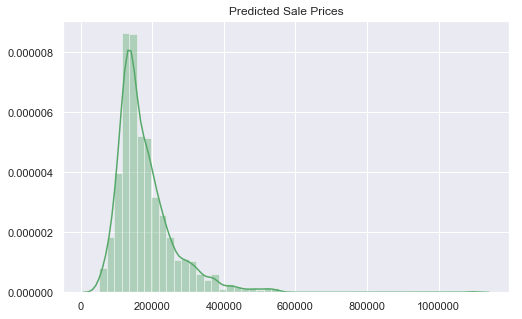

In [71]:
# View the distribution of SalePrice

fig, ax = plt.subplots(figsize=(8,5))
g = sns.distplot(price_predict, 
                 color="g",  
                 hist_kws=dict(edgecolor="w", linewidth=1), ax=ax);
plt.title("Predicted Sale Prices");

In [72]:
solution.head()

,Id,SalePrice
0,1461,115484.242798
1,1462,157731.036219
2,1463,181319.218324
3,1464,197098.152924
4,1465,192031.213308
